# Performance Evaluation

Two graphics will be generated for downlink and uplink direction:
- Throughput vs # of cores
- CPU usage per core

IndexError: list index out of range

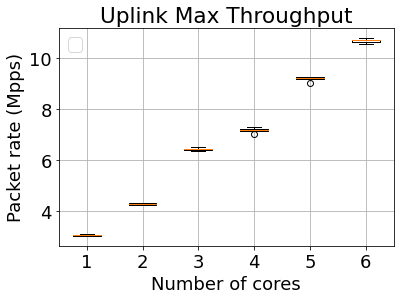

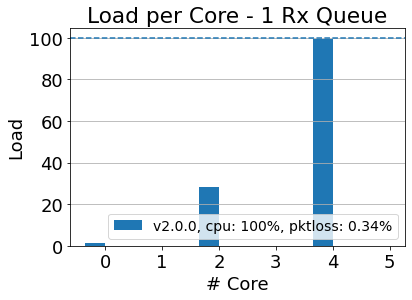

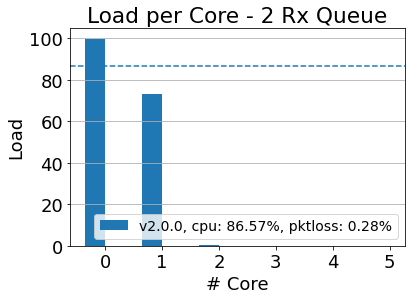

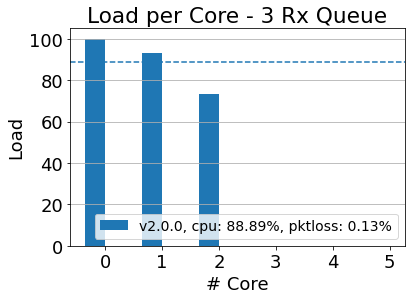

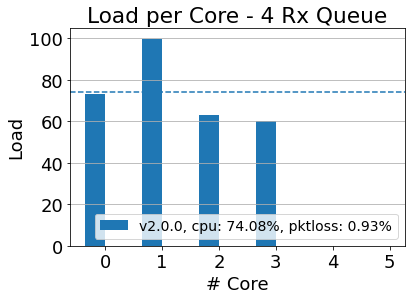

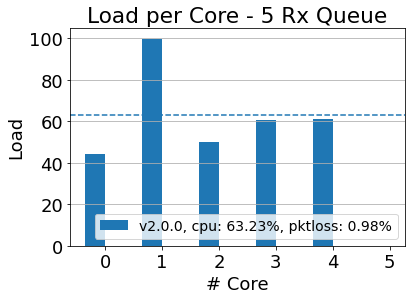

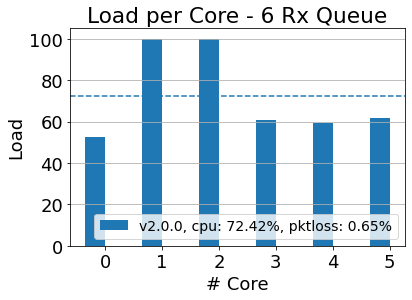

In [26]:
import json
import numpy as np
import matplotlib.pyplot as plt

# increase font size
plt.rcParams.update({'font.size': 18})


def get_throughputs(dict_output):
    array = []
    array_run = []
    for idx, item in enumerate(dict_output["items"]):
          if(idx%6 == 0 and idx != 0):
            array.append(array_run)
            array_run = []
          array_run.append(item["throughput"])
    return np.array(array)


def get_packet_loss(dict_output):
    array = []
    for item in dict_output["items"]:
        array.append(item["loss"])
    return np.array(array)


def get_soft_loads(dict_output):
    matriz = []
    for item in dict_output["items"]:
        array = []
        ids = []
        for i, cpu_load in enumerate(item["mpstat"]["sysstat"]["hosts"][0]["statistics"][0]["cpu-load"]):
            array.append(cpu_load["soft"])
            # It will override each iteraction.
            ids.append(cpu_load["cpu"])
        matriz.append(array)
    return np.array(matriz), np.array(ids)


# versions = ["v1.0.0", "v2.0.0"]
versions = ["v2.0.0"]
profile = [
    {
        'filename': 'UplinkMaxThoughtput.json',
        'title': 'Uplink Max Throughput'
    },
    {
        'filename': 'DownlinkMaxThoughtput.json',
        'title': 'Downlink Max Throughput'
    }
]
reports_path = "tests/reports/"
for idx, _ in enumerate(profile):
    fig, ax = plt.subplots()

    load_plots = None
    for i in range(6):
        if(load_plots == None):
            load_plots = [plt.subplots()]
        else:
            load_plots += [plt.subplots()]

    width = 0.35  # the width of the bars
    delta = -width/2
    for version in versions:
        filename = os.path.join(reports_path, version, profile[idx]['filename'])
        test_title = profile[idx]['title']

        with open(filename, "r") as report:
            dict_output = json.load(report)
            y = get_throughputs(dict_output)
            y_loads, ids = get_soft_loads(dict_output)
            loss_array = get_packet_loss(dict_output)

        x = np.arange(1, len(y_loads) + 1, 1)

        # ax.plot(x, y, 'o', ls='-', ms=4, label=version)
        ax.legend(versions)

        ax.boxplot(y)

        ax.set(xlabel='Number of cores', ylabel='Packet rate (Mpps)',
               title=test_title)
        ax.grid()

        n_tests, _ = y_loads.shape
        for i, y_load in enumerate(y_loads, 1):
            fig2, ax2 = load_plots[i-1]
            # Skip cpu "all"
            y = y_load[1:]
            x = ids[1:].astype(np.float32)

            # workaround due to CPU usage in another core. I dont know yet why it happend.
            mean = 100 if (i==1) else round(np.mean(y[:i]), 2)

            pkt_loss = round(loss_array[i-1]*100, 2)

            textstr = "{}, cpu: {}%, pktloss: {}%".format(
                version, mean, pkt_loss)
            bar = ax2.bar(x + delta, y, width, label=textstr)
            ax2.axhline(mean, linestyle="--", color=bar[-1].get_facecolor())
            ax2.legend(loc='lower right', fontsize=14)

            load_title = 'Load per Core - {} Rx Queue'.format(i)
            ax2.set(xlabel='# Core', ylabel='Load', title=load_title)
            ax2.yaxis.grid()

        # for bar graphs to shift to the right.
        delta += width
    
    img_path = os.path.join(reports_path, "img")

    # save figure throughput vs #core.
    fig.savefig(os.path.join(img_path, test_title + ".svg"),
                bbox_inches='tight', format='svg')

    # save figures cpu usage per core.
    for i, (fig, ax) in enumerate(load_plots, 1):
        load_title = 'Load per Core - {} Rx Queue'.format(i)
        fig.savefig(os.path.join(img_path, test_title + load_title + ".svg"),
                    bbox_inches='tight', format='svg')


print(y)
